In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import cPickle as pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import savgol_filter
from scipy.io import loadmat
from scipy.interpolate import spline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

from matplotlib.ticker import MaxNLocator
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input, ZeroPadding2D,merge,Lambda
from keras.layers.convolutional import Convolution2D
from keras.models import Model
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.optimizers import SGD
from keras import backend as K
from keras.engine import Layer
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from keras.layers.core import  Lambda
from keras.regularizers import l2
#import hdbscan
import cv2
#}

Using Theano backend.


In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
def preprocess_image_batch(image_paths, image_height=224, image_width=224,color_mode='rgb'):
    """resize images to the appropriate dimensions
    :param image_width:
    :param image_height:
    :param image: image
    :return: image
    """
    img_list = []
    
    for im_path in image_paths:
        image = cv2.imread(im_path)
        image = cv2.resize(image, (image_height, image_width))
    
        if color_mode == 'bgr':
            image = image.transpose((2, 0, 1))
        img_list.append(image)
        
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print im_path
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')
    return img_batch

In [4]:
#Helper function to normalization across channels
K.set_image_dim_ordering('th')
def crosschannelnormalization(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    """
    This is the function used for cross channel normalization in the original
    Alexnet
    """
    def f(X):
        if K.image_dim_ordering()=='tf':
            b, r, c, ch = X.get_shape()
        else:
            b, ch, r, c = X.shape

        half = n // 2
        square = K.square(X)
        scale = k
        if K.image_dim_ordering() == 'th':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0,0),(half,half)))
            extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
            for i in range(n):
                scale += alpha * extra_channels[:, i:i+ch, :, :]
        if K.image_dim_ordering() == 'tf':
            extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 3, 1, 2)), (half, 0))
            extra_channels = K.permute_dimensions(extra_channels, (0, 2, 3, 1))
            for i in range(n):
                scale += alpha * extra_channels[:, :, :, i:i+int(ch)]
        scale = scale ** beta
        return X / scale


    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [5]:
#Helper Function to split tensor
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = K.shape(X)[axis] // ratio_split

        if axis == 0:
            output = X[id_split*div:(id_split+1)*div, :, :, :]
        elif axis == 1:
            output = X[:, id_split*div:(id_split+1)*div, :, :]
        elif axis == 2:
            output = X[:, :, id_split*div:(id_split+1)*div, :]
        elif axis == 3:
            output = X[:, :, :, id_split*div:(id_split+1)*div]
        else:
            raise ValueError("This axis is not possible")
        return output

    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)


    return Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

In [6]:
#Alexnet layer architecture class
def AlexNet(img_shape=(3, 227, 227), n_classes=1000, l2_reg=0.,weights_path=None, lambda_mask=None):

    dim_ordering = K.image_dim_ordering()
    print dim_ordering
    if dim_ordering == 'th':
        batch_index = 0
        channel_index = 1
        row_index = 2
        col_index = 3
    if dim_ordering == 'tf':
        batch_index = 0
        channel_index = 3
        row_index = 1
        col_index = 2
        
    
    inputs = Input(img_shape)

    conv_1 = Convolution2D(96, 11, 11, subsample=(4, 4), activation='relu',
                           name='conv_1', W_regularizer=l2(l2_reg))(inputs)

    if lambda_mask is not None:
        conv_1_mask  = np.reshape(lambda_mask[0:290400], (96,55,55))
    else:
        conv_1_mask = np.ones(shape=((96, 55, 55)))
    
    conv_1_mask  = K.variable(conv_1_mask)
    conv_1_lambda = Lambda(lambda x: x * conv_1_mask)(conv_1)

    conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1_lambda)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2, 2))(conv_2)
    conv_2 = merge([
        Convolution2D(128, 5, 5, activation="relu", name='conv_2_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_2)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_2")

    if lambda_mask is not None:
        conv_2_mask  = np.reshape(lambda_mask[290400:477024],(256, 27, 27) )
    else:
        conv_2_mask = np.ones(shape=((256, 27, 27)))
        
    conv_2_mask = K.variable(conv_2_mask)
    conv_2_lambda = Lambda(lambda x: x * conv_2_mask)(conv_2)

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2_lambda)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Convolution2D(384, 3, 3, activation='relu', name='conv_3',
                           W_regularizer=l2(l2_reg))(conv_3)

    if lambda_mask is not None:
        conv_3_mask  = np.reshape(lambda_mask[477024:541920],(384, 13, 13))
    else:
        conv_3_mask = np.ones(shape=((384, 13, 13)))
    
    conv_3_mask = K.variable(conv_3_mask)
    conv_3_lambda = Lambda(lambda x: x * conv_3_mask)(conv_3)

    conv_4 = ZeroPadding2D((1, 1))(conv_3_lambda)
    conv_4 = merge([
        Convolution2D(192, 3, 3, activation="relu", name='conv_4_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_4)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_4")

    if lambda_mask is not None:
        conv_4_mask  = np.reshape(lambda_mask[541920:606816],(384, 13, 13))
    else:
        conv_4_mask = np.ones(shape=((384, 13, 13)))
        
    conv_4_mask = K.variable(conv_4_mask)
    conv_4_lambda = Lambda(lambda x: x * conv_4_mask)(conv_4)

    conv_5 = ZeroPadding2D((1, 1))(conv_4_lambda)
    conv_5 = merge([
        Convolution2D(128, 3, 3, activation="relu", name='conv_5_'+str(i+1),
                      W_regularizer=l2(l2_reg))(
            splittensor(axis=channel_index, ratio_split=2, id_split=i)(conv_5)
        ) for i in range(2)], mode='concat', concat_axis=channel_index, name="conv_5")

    if lambda_mask is not None:
        conv_5_mask  = np.reshape(lambda_mask[606816:650080],(256, 13, 13))
    else:
        conv_5_mask = np.ones(shape=((256, 13, 13)))
    
    conv_5_mask = K.variable(conv_5_mask)
    conv_5_lambda = Lambda(lambda x: x * conv_5_mask)(conv_5)

    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name="convpool_5")(conv_5_lambda)

    dense_1 = Flatten(name="flatten")(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1',
                    W_regularizer=l2(l2_reg))(dense_1)

    if lambda_mask is not None:
        dense_1_mask  = np.reshape(lambda_mask[650080:654176],(4096,))
    else:
        dense_1_mask = np.ones(shape=((4096,)))
    
    
    dense_1_mask = K.variable(dense_1_mask)
    dense_1_lambda = Lambda(lambda x: x * dense_1_mask)(dense_1)

    dense_2 = Dropout(0.5)(dense_1_lambda)
    dense_2 = Dense(4096, activation='relu', name='dense_2',
                    W_regularizer=l2(l2_reg))(dense_2)

    if lambda_mask is not None:
        dense_2_mask  = np.reshape(lambda_mask[654176:658272],(4096,))
    else:
        dense_2_mask = np.ones(shape=((4096,)))
    
    dense_2_mask = K.variable(dense_2_mask)
    dense_2_lambda = Lambda(lambda x: x * dense_2_mask)(dense_2)

    dense_3 = Dropout(0.5)(dense_2_lambda)
    if n_classes == 1000:
        dense_3 = Dense(n_classes, name='dense_3',
                        W_regularizer=l2(l2_reg))(dense_3)

    else:
        # We change the name so when loading the weights_file from a
        # Imagenet pretrained model does not crash
        dense_3 = Dense(n_classes, name='dense_3_new',
                        W_regularizer=l2(l2_reg))(dense_3)

    prediction = Activation("softmax", name="softmax")(dense_3)

    model = Model(input=inputs, output=prediction)
    if weights_path:
        model.load_weights(weights_path)

    return model

In [7]:
model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5")
model.summary()            

th
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 227, 227)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 96, 55, 55)   34944       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 96, 55, 55)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 27, 27)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
convpoo

Total params: 60,965,224
Trainable params: 60,965,224
Non-trainable params: 0
__________________________________________________________________________________________________


In [8]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids


In [9]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print '##########', ind_
            pass
        line_num += 1
#}

In [10]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error


In [10]:
%%time
#Test Cell 1
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

data_path = '../../data/pkl/'
classes = ['animate','inanimate']
fold = 1

with open(data_path+classes[0]+'_train.pkl') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
X = np.column_stack((X_fold,y_fold))
X = np.float32(X)

kmeans = MiniBatchKMeans(n_clusters=65827,
                         batch_size=6,
                         max_iter=10).fit(X)
kmeans.cluster_centers_
pred_kmeans = kmeans.predict(X)
X_new = kmeans.cluster_centers_

with open('../../data/pkl/kmeans_first_train.pickle', 'wb') as handle:
    pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


CPU times: user 4h 35min 49s, sys: 3h 44min 44s, total: 8h 20min 34s
Wall time: 1h 13min 15s


In [ ]:
with open('../../data/pkl/kmeans_first_train.pickle',"rb") as f:
    X_new,pred_kmeans,kmeans = pickle.load(f)

In [ ]:
X_new.dtype

In [ ]:
%%time
#Test Cell 2
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
result= {}   

j=14
clf_result = {}
clf_result[j] = {}
#clf = KMeans(n_clusters=j)
#clf = SpectralClustering(n_clusters=j,assign_labels="discretize")
clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
#clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
#clf = GaussianMixture(n_components=j, covariance_type='full')
y_pred = clf.fit_predict(X_new)


for label in set(clf.labels_):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
 
    lambda_mask = np.ones(shape=((658272,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 

    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
    model.compile(optimizer=sgd, loss='mse')

    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
        with open(image_list_valid,'rb') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error

    result[label] = dprime
    #clf_result[j][label] = dprime
    
#with open('../../data/pkl/30_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
#    pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

#result[fold] = clf_result


In [ ]:
'''
https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/
Sklearn-Kmeans+
Sklearn DBSCAN - https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
HDBSCAN - conda install -c conda-forge hdbscan
Sklearn Single Linkage+
Birch+
DeBacl Geom Tree - pip install debacl
Agglomerative clustering - Ward Linkage+
Mean Shift - Bandwith scree plot?
GMM+
SMM - pip install smm --user+
Genie - https://github.com/gagolews/genieclust/blob/master/example_genie_basic.ipynb
DEC-Keras - Sometime in the near future?
'''

In [22]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'.pickle'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=65827,
                                 random_state=0,
                                 batch_size=6,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    from sklearn.cluster import SpectralClustering
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,14,1):
 
        clf_result[j] = {}
       
        print j, 2**j

        clf = KMeans(n_clusters=j)    
        #clf =  AgglomerativeClustering(n_clusters=j, linkage='ward')
        #clf = Birch(branching_factor=50, n_clusters=j, threshold=0.5,compute_labels=True)
        clf = GaussianMixture(n_components=2**j, covariance_type='full')
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((658272,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,227,227, color_mode="bgr")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            clf_result[j][label] = dprime
    
    with open('../../data/pkl/'+str(method)+'_multi_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
    if fold == 2:
        break
#}

('Perfoming Fold: ', 1)
GMM
1
('Cluster: ', 1, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 20 39 0.487179487179
('Cluster: ', 1, 'Label: ', 1)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
2
('Cluster: ', 2, 'Label: ', 0)
th
animate 1 0 39 1.0
inanimate 1 5 39 0.871794871795
('Cluster: ', 2, 'Label: ', 1)
th
animate 1 9 39 0.769230769231
inanimate 1 31 39 0.205128205128
('Cluster: ', 2, 'Label: ', 2)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 2, 'Label: ', 3)
th
animate 1 13 39 0.666666666667
inanimate 1 24 39 0.384615384615
3
('Cluster: ', 3, 'Label: ', 0)
th
animate 1 26 39 0.333333333333
inanimate 1 28 39 0.282051282051
('Cluster: ', 3, 'Label: ', 1)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster: ', 3, 'Label: ', 2)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 3, 'Label: ', 3)
th
animate 1 13 39 0.666666666667
inanimate 1 32 39 0.179487179487
('Cluster: ', 3, 'Label: ', 4)
th
animate 1 0 39 1.0
inanimate 1 0 39 1.0
('Cluster:

th
animate 1 26 39 0.333333333333
inanimate 1 29 39 0.25641025641
('Cluster: ', 6, 'Label: ', 24)
th
animate 1 34 39 0.128205128205
inanimate 1 21 39 0.461538461538
('Cluster: ', 6, 'Label: ', 25)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 26)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 27)
th
animate 1 31 39 0.205128205128
inanimate 1 17 39 0.564102564103
('Cluster: ', 6, 'Label: ', 28)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 29)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 30)
th
animate 1 28 39 0.282051282051
inanimate 1 31 39 0.205128205128
('Cluster: ', 6, 'Label: ', 31)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 32)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 6, 'Label: ', 33)
th
animate 

inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 43)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 44)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 45)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 46)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 47)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 48)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 49)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 50)
th
animate 1 31 39 0.205128205128
inanimate 1 25 39 0.358974358974
('Cluster: ', 7, 'Label: ', 51)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 52)
th
animate 1 33 39 0.153846153846
inanimate 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 7, 'Label: ', 126)
th
animate 1 32 39 0.179487179487
inanimate 1 23 39 0.410256410256
('Cluster: ', 7, 'Label: ', 127)
th
animate 1 32 39 0.179487179487
inanimate 1 25 39 0.358974358974
8
('Cluster: ', 8, 'Label: ', 0)
th
animate 1 33 39 0.153846153846
inanimate 1 25 39 0.358974358974
('Cluster: ', 8, 'Label: ', 1)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 2)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 3)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 4)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 8, 'Label: ', 5)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 6)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 7)
th
animate 1 33 3

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 81)
th
animate 1 30 39 0.230769230769
inanimate 1 29 39 0.25641025641
('Cluster: ', 8, 'Label: ', 82)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 83)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 84)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 85)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 8, 'Label: ', 86)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 8, 'Label: ', 87)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 88)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 89)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 8, 'Label: ', 90)
th
animate 1 3

inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 163)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 164)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 165)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 166)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 167)
th
animate 1 21 39 0.461538461538
inanimate 1 29 39 0.25641025641
('Cluster: ', 8, 'Label: ', 168)
th
animate 1 29 39 0.25641025641
inanimate 1 29 39 0.25641025641
('Cluster: ', 8, 'Label: ', 169)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 170)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 171)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 172)
th
animate 1 32 39 0.179487179487
ina

inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 245)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 246)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 247)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 248)
th
animate 1 29 39 0.25641025641
inanimate 1 29 39 0.25641025641
('Cluster: ', 8, 'Label: ', 249)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 8, 'Label: ', 250)
th
animate 1 32 39 0.179487179487
inanimate 1 29 39 0.25641025641
('Cluster: ', 8, 'Label: ', 251)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 252)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 253)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 8, 'Label: ', 254)
th
animate 1 31 39 0.205128205128
ina

inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 72)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 73)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 74)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 75)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 76)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 77)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 78)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 79)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 80)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 81)
th
animate 1 33 39 0.153846153846
inanimate 

animate 1 30 39 0.230769230769
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 155)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 156)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 157)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 158)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 159)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 160)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 161)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 162)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 163)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 164)
th


animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 237)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 238)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 239)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 240)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 241)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 242)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 243)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 244)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 245)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 246)
th


animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 319)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 320)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 321)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 322)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 323)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 324)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 325)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 326)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 327)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 328)
th


animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 9, 'Label: ', 401)
th
animate 1 32 39 0.179487179487
inanimate 1 29 39 0.25641025641
('Cluster: ', 9, 'Label: ', 402)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 9, 'Label: ', 403)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 404)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 405)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 406)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 407)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 408)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 409)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 410)
th
a

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 483)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 484)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 485)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 486)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 487)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 488)
th
animate 1 30 39 0.230769230769
inanimate 1 29 39 0.25641025641
('Cluster: ', 9, 'Label: ', 489)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 490)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 491)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 9, 'Label: ', 492)
th
a

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 53)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 54)
th
animate 1 36 39 0.0769230769231
inanimate 1 34 39 0.128205128205
('Cluster: ', 10, 'Label: ', 55)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 56)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 57)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 58)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 59)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 60)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 61)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 62)
th
animate 1 31 39 0.205128205128

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 135)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 136)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 137)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 138)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 139)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 10, 'Label: ', 140)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 141)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 142)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 143)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 216)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 217)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 218)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 219)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 220)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 221)
th
animate 1 30 39 0.230769230769
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 222)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 223)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 224)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 225)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 298)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 299)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 300)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 301)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 302)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 303)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 304)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 305)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 306)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 379)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 380)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 381)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 382)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 383)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 384)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 385)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 386)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 387)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 388)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 461)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 462)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 463)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 464)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 465)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 466)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 467)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 468)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 469)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 542)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 543)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 544)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 545)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 546)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 547)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 548)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 549)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 550)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 551)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 624)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 625)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 626)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 627)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 628)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 629)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 630)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 631)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 632)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 705)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 706)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 707)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 708)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 709)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 710)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 10, 'Label: ', 711)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 712)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 713)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 714)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 787)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 788)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 789)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 790)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 791)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 792)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 793)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 794)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 795)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 868)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 869)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 870)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 871)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 872)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 873)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 874)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 875)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 876)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 877)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 950)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 951)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 952)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 953)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 954)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 955)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 956)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 957)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: ', 958)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 10, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 7)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 8)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 9)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 10)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 11)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 12)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 13)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 14)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 15)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 16)
th
animate 1 33 39 0.153846153846
ina

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 89)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 90)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 91)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 92)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 93)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 94)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 95)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 96)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 97)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 98)
th
animate 1 33 39 0.153846153846


animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 171)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 172)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 173)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 174)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 175)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 176)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 177)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 178)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 179)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 252)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 253)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 254)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 255)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 256)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 257)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 258)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 259)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 260)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 261)
th
animate 1 32 39 0.179

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 334)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 335)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 336)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 337)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 338)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 339)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 340)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 341)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 342)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 415)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 416)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 417)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 418)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 419)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 420)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 421)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 422)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 423)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 424)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 497)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 498)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 499)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 500)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 501)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 502)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 503)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 504)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 505)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 578)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 579)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 580)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 581)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 582)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 583)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 584)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 585)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 586)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 587)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 660)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 661)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 662)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 663)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 664)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 665)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 666)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 667)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 668)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 741)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 742)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 743)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 744)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 745)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 746)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 747)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 748)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 749)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 750)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 823)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 824)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 825)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 826)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 827)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 828)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 829)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 830)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 831)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 904)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 905)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 906)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 907)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 908)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 909)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 910)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 911)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 912)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 913)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 986)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 987)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 988)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 989)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 990)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 991)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 992)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 993)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 994)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: '

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1067)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1068)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1069)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1070)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1071)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1072)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 1073)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1074)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1075)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1148)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1149)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1150)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1151)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1152)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1153)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1154)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1155)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1156)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1229)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1230)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1231)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1232)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1233)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1234)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1235)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1236)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1237)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1310)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1311)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1312)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1313)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 1314)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1315)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1316)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1317)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1318)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1391)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1392)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1393)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1394)
th
animate 1 37 39 0.0512820512821
inanimate 1 33 39 0.153846153846
('Cluster: ', 11, 'Label: ', 1395)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1396)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1397)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1398)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1399)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 11,

animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1472)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1473)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1474)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 11, 'Label: ', 1475)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1476)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1477)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1478)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1479)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1480)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1553)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1554)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1555)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1556)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1557)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1558)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1559)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1560)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1561)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1634)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1635)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1636)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1637)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1638)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1639)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1640)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1641)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1642)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1715)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1716)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1717)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1718)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1719)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1720)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1721)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1722)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1723)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1796)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1797)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1798)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1799)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1800)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1801)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1802)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1803)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1804)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1877)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1878)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1879)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1880)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1881)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1882)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1883)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1884)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1885)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1958)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1959)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1960)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1961)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1962)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1963)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1964)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1965)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 1966)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2039)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2040)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2041)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2042)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2043)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2044)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2045)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2046)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 11, 'Label: ', 2047)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
12
('Cluster: ', 1

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 73)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 74)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 75)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 76)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 77)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 78)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 79)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 80)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 81)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 82)
th


animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 155)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 156)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 157)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 158)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 159)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 160)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 161)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 162)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 163)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 236)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 237)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 238)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 239)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 240)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 241)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 242)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 243)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 244)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 245)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 318)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 319)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 320)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 321)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 322)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 323)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 324)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 325)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 326)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 399)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 400)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 401)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 402)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 403)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 404)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 405)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 406)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 407)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 408)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 481)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 482)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 483)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 484)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 485)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 486)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 487)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 488)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 489)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 562)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 563)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 564)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 565)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 566)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 567)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 568)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 569)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 570)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 571)
th
animate 1 33 39 0.153

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 644)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 645)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 646)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 647)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 648)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 649)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 650)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 651)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 652)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 725)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 726)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 727)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 728)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 729)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 730)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 731)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 732)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 733)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 734)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 807)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 808)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 809)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 810)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 811)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 812)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 813)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 814)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 815)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 888)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 889)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 890)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 891)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 892)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 893)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 894)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 895)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 896)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 897)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 970)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 971)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 972)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 973)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 974)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 975)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 976)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 977)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 978)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: '

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1051)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1052)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1053)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1054)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1055)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1056)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1057)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1058)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1059)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1132)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1133)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1134)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1135)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1136)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1137)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1138)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1139)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1140)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1213)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1214)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1215)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1216)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 1217)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1218)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1219)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1220)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1221)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1294)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1295)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1296)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1297)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1298)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1299)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1300)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1301)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1302)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1375)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1376)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1377)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1378)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1379)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 1380)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1381)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1382)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1383)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1456)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1457)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1458)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1459)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1460)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1461)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1462)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1463)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1464)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1537)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1538)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1539)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1540)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1541)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1542)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1543)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1544)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1545)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1618)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1619)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1620)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1621)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1622)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1623)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1624)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1625)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1626)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1699)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1700)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1701)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1702)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1703)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1704)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1705)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1706)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1707)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1780)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1781)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1782)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1783)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1784)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1785)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1786)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1787)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1788)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1861)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1862)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1863)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1864)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1865)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1866)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1867)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1868)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1869)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1942)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1943)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1944)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1945)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1946)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1947)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1948)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1949)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 1950)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2023)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2024)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2025)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2026)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2027)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2028)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2029)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2030)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2031)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2104)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2105)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2106)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2107)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2108)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2109)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2110)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2111)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2112)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2185)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2186)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2187)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2188)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2189)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2190)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2191)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2192)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2193)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 2266)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2267)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2268)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2269)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2270)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2271)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2272)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2273)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2274)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2347)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2348)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2349)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2350)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2351)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2352)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2353)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2354)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2355)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2428)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2429)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2430)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2431)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2432)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2433)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2434)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2435)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2436)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2509)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2510)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2511)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2512)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2513)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2514)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2515)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2516)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2517)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2590)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2591)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2592)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2593)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2594)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2595)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2596)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2597)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2598)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2671)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2672)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2673)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2674)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2675)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2676)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2677)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2678)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2679)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2752)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2753)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2754)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2755)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2756)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2757)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2758)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2759)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2760)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2833)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 2834)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 2835)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2836)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2837)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2838)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2839)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2840)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2841)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2914)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2915)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2916)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2917)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2918)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2919)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2920)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2921)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2922)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2995)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2996)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2997)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2998)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 2999)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3000)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3001)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3002)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3003)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3076)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3077)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3078)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3079)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3080)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3081)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3082)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3083)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3084)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3157)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3158)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3159)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3160)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3161)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3162)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3163)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3164)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3165)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3238)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3239)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3240)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3241)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3242)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3243)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3244)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3245)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3246)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3319)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3320)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3321)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3322)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3323)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 3324)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3325)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3326)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3327)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3400)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3401)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 12, 'Label: ', 3402)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3403)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3404)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3405)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3406)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3407)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3408)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3481)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3482)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3483)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3484)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3485)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3486)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3487)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3488)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3489)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3562)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3563)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3564)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3565)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3566)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3567)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3568)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3569)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3570)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3643)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3644)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3645)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3646)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3647)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3648)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3649)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3650)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3651)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3724)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3725)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3726)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3727)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3728)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3729)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3730)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3731)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3732)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3805)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3806)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3807)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3808)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3809)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3810)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3811)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3812)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3813)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3886)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3887)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3888)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3889)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3890)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3891)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3892)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3893)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3894)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3967)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3968)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3969)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3970)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3971)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3972)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3973)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3974)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 3975)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4048)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4049)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4050)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4051)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4052)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4053)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4054)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4055)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 'Label: ', 4056)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 12, 

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 33)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 34)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 35)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 36)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 37)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 38)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 39)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 40)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 41)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 42)
th
animate 1 33 39 0.153846153846


inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 115)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 116)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 117)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 118)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 119)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 120)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 121)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 122)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 123)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 124)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 197)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 198)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 199)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 200)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 201)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 202)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 203)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 204)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 205)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 278)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 279)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 280)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 281)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 282)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 283)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 284)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 285)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 286)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 287)
th
animate 1 33 39 0.153

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 360)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 361)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 362)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 363)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 364)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 365)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 366)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 367)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 368)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 441)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 442)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 443)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 444)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 445)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 446)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 447)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 448)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 449)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 450)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 523)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 524)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 525)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 526)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 527)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 528)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 529)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 530)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 531)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 604)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 605)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 606)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 607)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 608)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 609)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 610)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 611)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 612)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 613)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 686)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 687)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 688)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 689)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 690)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 691)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 692)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 693)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 694)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 767)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 768)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 769)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 770)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 771)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 772)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 773)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 774)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 775)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 776)
th
animate 1 33 39 0.153

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 849)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 850)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 851)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 852)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 853)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 854)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 855)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 856)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 857)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: '

inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 930)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 931)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 932)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 933)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 934)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 935)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 936)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 937)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 938)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 939)
th
animate 1 32 39 0.179

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1012)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1013)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1014)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1015)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1016)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1017)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1018)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1019)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1020)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1093)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1094)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1095)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1096)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1097)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1098)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1099)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1100)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1101)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1174)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1175)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1176)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1177)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1178)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1179)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1180)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1181)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1182)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1255)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1256)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1257)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1258)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1259)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1260)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1261)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1262)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1263)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1336)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1337)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1338)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1339)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1340)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1341)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1342)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1343)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1344)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1417)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1418)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1419)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1420)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1421)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1422)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1423)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1424)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1425)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1498)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1499)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1500)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1501)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1502)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1503)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1504)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1505)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1506)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1579)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1580)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1581)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1582)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1583)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1584)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1585)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1586)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1587)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1660)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1661)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1662)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1663)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1664)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1665)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1666)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1667)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1668)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1741)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1742)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1743)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1744)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1745)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1746)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1747)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1748)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1749)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1822)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1823)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1824)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1825)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1826)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1827)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1828)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1829)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1830)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1903)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1904)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1905)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1906)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1907)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1908)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1909)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1910)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1911)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1984)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1985)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1986)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1987)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1988)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1989)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1990)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1991)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 1992)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2065)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2066)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2067)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2068)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2069)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2070)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2071)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2072)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2073)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2146)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2147)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2148)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2149)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2150)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2151)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2152)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2153)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 13, 'Label: ', 2154)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2227)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2228)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2229)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2230)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2231)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2232)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2233)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2234)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2235)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2308)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2309)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2310)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2311)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2312)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2313)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2314)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2315)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2316)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2389)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2390)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2391)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2392)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2393)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2394)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2395)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2396)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2397)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2470)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2471)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2472)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2473)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2474)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2475)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2476)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2477)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2478)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2551)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2552)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2553)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2554)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2555)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2556)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2557)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2558)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2559)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2632)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2633)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2634)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2635)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2636)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2637)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2638)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2639)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2640)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2713)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2714)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2715)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2716)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2717)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2718)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2719)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2720)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2721)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2794)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2795)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2796)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2797)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2798)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2799)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2800)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2801)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2802)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2875)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2876)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2877)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2878)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2879)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2880)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2881)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2882)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2883)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2956)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2957)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2958)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2959)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2960)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2961)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2962)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2963)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 2964)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3037)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3038)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3039)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3040)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3041)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3042)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3043)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3044)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3045)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3118)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3119)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3120)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3121)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3122)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3123)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3124)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3125)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3126)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3199)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3200)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3201)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3202)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3203)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3204)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3205)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3206)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3207)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3280)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3281)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3282)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3283)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3284)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3285)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3286)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3287)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3288)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3361)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3362)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3363)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3364)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3365)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3366)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3367)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3368)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3369)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3442)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3443)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3444)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3445)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3446)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3447)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3448)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3449)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3450)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3523)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3524)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3525)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3526)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3527)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3528)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3529)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3530)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3531)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3604)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3605)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3606)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3607)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3608)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3609)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3610)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3611)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3612)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3685)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3686)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3687)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3688)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3689)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3690)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3691)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3692)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3693)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3766)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3767)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3768)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3769)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3770)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3771)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3772)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3773)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3774)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3847)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3848)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3849)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3850)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3851)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3852)
th
animate 1 33 39 0.153846153846
inanimate 1 27 39 0.307692307692
('Cluster: ', 13, 'Label: ', 3853)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3854)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3855)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3928)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3929)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3930)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3931)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3932)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3933)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3934)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3935)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 3936)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4009)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4010)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4011)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4012)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4013)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4014)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4015)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4016)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4017)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4090)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4091)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4092)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4093)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4094)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4095)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4096)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4097)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4098)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4171)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4172)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4173)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4174)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4175)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4176)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4177)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4178)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4179)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4252)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4253)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4254)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4255)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4256)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4257)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4258)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4259)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4260)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4333)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4334)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4335)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4336)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4337)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4338)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4339)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4340)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4341)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4414)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4415)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4416)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4417)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4418)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4419)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4420)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4421)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4422)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4495)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4496)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4497)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4498)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4499)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4500)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4501)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4502)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4503)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4576)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4577)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4578)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4579)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4580)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4581)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4582)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4583)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4584)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4657)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4658)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4659)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4660)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4661)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4662)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4663)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4664)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4665)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4738)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4739)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4740)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4741)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4742)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4743)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4744)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4745)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4746)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4819)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4820)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4821)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4822)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4823)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4824)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4825)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4826)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4827)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4900)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4901)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4902)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4903)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4904)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4905)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4906)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4907)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4908)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4981)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4982)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4983)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4984)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4985)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4986)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4987)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4988)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 4989)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5062)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5063)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5064)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5065)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5066)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5067)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5068)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5069)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5070)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5143)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5144)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5145)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5146)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5147)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5148)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5149)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5150)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5151)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5224)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5225)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5226)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5227)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5228)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5229)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5230)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5231)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5232)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5305)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5306)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5307)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5308)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5309)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5310)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5311)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5312)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5313)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5386)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5387)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5388)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5389)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5390)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5391)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5392)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5393)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5394)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5467)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5468)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5469)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5470)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5471)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5472)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5473)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5474)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5475)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5548)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5549)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5550)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5551)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5552)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5553)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5554)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5555)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5556)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5629)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5630)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5631)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5632)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5633)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5634)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5635)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5636)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5637)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5710)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5711)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5712)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5713)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5714)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5715)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5716)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5717)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5718)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5791)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5792)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5793)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5794)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5795)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5796)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 13, 'Label: ', 5797)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5798)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5799)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5872)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5873)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5874)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5875)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5876)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5877)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5878)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5879)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5880)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5953)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5954)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5955)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5956)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5957)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5958)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5959)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5960)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 5961)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6034)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6035)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6036)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6037)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6038)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6039)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6040)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6041)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6042)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6115)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6116)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6117)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6118)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6119)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6120)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6121)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6122)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6123)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6196)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6197)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6198)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6199)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6200)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6201)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6202)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6203)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6204)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6277)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6278)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6279)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6280)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6281)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6282)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6283)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6284)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6285)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6358)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6359)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6360)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6361)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6362)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6363)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6364)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6365)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6366)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6439)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6440)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6441)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6442)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6443)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6444)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6445)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6446)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6447)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6520)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6521)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6522)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6523)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6524)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6525)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6526)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6527)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6528)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6601)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6602)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6603)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6604)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6605)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6606)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6607)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6608)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6609)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6682)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6683)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6684)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6685)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6686)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6687)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6688)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6689)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6690)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6763)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6764)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6765)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6766)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6767)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6768)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6769)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6770)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6771)
th
animate 1 32 39 0.179487179487
inanimate 1 27 39 0.307692307692
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6844)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6845)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6846)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6847)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6848)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6849)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6850)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6851)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6852)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6925)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6926)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6927)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6928)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6929)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6930)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6931)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6932)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 6933)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7006)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7007)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7008)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7009)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7010)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7011)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7012)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7013)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7014)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7087)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7088)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7089)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7090)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7091)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7092)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7093)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7094)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7095)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7168)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7169)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7170)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7171)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7172)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7173)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7174)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7175)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7176)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7249)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7250)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7251)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7252)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7253)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7254)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7255)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7256)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7257)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7330)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7331)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7332)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7333)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7334)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7335)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7336)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7337)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7338)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7411)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7412)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7413)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7414)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7415)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7416)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7417)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7418)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7419)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7492)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7493)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7494)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7495)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7496)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7497)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7498)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7499)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7500)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7573)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7574)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7575)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7576)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7577)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7578)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7579)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7580)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7581)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7654)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7655)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7656)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7657)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7658)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7659)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7660)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7661)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7662)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7735)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7736)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7737)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7738)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7739)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7740)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7741)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7742)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7743)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7816)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7817)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7818)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7819)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7820)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7821)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7822)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7823)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7824)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7897)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7898)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7899)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7900)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7901)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7902)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7903)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7904)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7905)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7978)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7979)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7980)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7981)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7982)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7983)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7984)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7985)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 7986)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8059)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8060)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8061)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8062)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8063)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8064)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8065)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8066)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8067)
th
animate 1 31 39 0.205128205128
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8140)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8141)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8142)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8143)
th
animate 1 32 39 0.179487179487
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8144)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8145)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8146)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8147)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 'Label: ', 8148)
th
animate 1 33 39 0.153846153846
inanimate 1 28 39 0.282051282051
('Cluster: ', 13, 

In [30]:
for j in range(1,14,1):
    print(2**j)

2
4
8
16
32
64
128
256
512
1024
2048
4096
8192


('Perfoming Fold: ', 1)
DBSCAN
('Perfoming Fold: ', 2)
DBSCAN
('Perfoming Fold: ', 3)
DBSCAN
('Perfoming Fold: ', 4)
DBSCAN
CPU times: user 2.55 s, sys: 20.2 ms, total: 2.57 s
Wall time: 762 ms


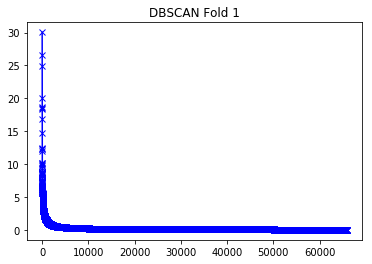

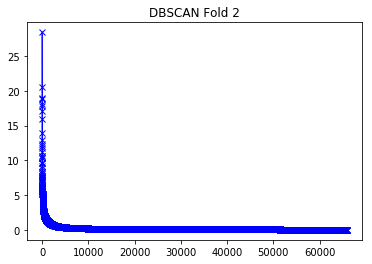

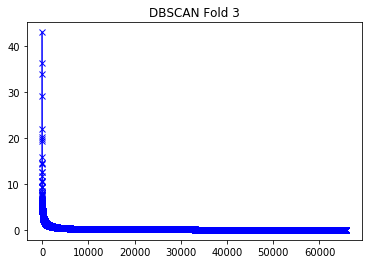

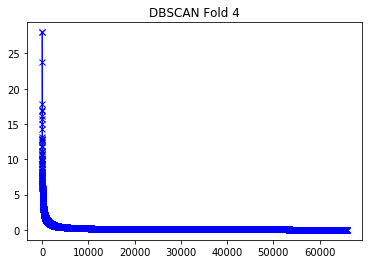

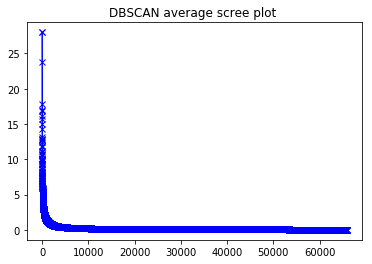

In [79]:
%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1
clf_result = {}
    
for i in range(k):

    print('Perfoming Fold: ', fold)
   
    
    if os.path.exists('../../data/pkl/kmeans_first_'+str(fold)+'.pickle'):
        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
            y_fold = pickle.load(f)
        
        #65827
        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=10, #Change This
                                 batch_size=6,
                                 max_iter=10).fit(X)
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl/kmeans_first_'+str(fold)+'.pickle', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    from sklearn.neighbors import NearestNeighbors
        
    method ='DBSCAN'
    print(method)
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X_new)
    distances, indices = nbrs.kneighbors(X_new)
    #print(distances,indices)
    distances = np.sort(distances, axis=0)[::-1]
    distances = distances[:,1]
    plt.figure(fold)
    plt.plot(distances,'bx-')
    plt.title(str(method)+' Fold '+ str(fold))
    
    for i in range(len(indices)):
        if clf_result.get(i,None) is None:
            clf_result[i] = 0.
        else:
            clf_result[i] += distances[i]
            
    with open('../../data/pkl/'+str(method)+'_scree_fold_'+str(fold)+'.pickle', 'wb') as handle:
        pickle.dump([distances, indices], handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = [distances, indices]
    fold += 1


for i in range(len(indices)):
    clf_result[i] =float(clf_result[i]) / 4.
dstances = clf_result.values()
dstances = np.sort(distances, axis=0)[::-1]

plt.figure(fold)
plt.plot(range(len(dstances)), dstances,'bx-')
plt.title(str(method)+' average scree plot ')

'''

print('y = [')
for i in range(len(dstances)):
    if i== len(dstances) -1:
        print dstances[i],']'
    else:
        print dstances[i],','

#Works Only with Python 3

import matplotlib
%matplotlib inline
from kneed import KneeLocator
y = [39.48572377,29.85299989 , 9.48860291 , 6.87495423 , 6.61210015 , 5.04854712 ,4.69691816,  3.80722248,  3.74839207 , 3.74839207]
kn = KneeLocator(range(len(y)), y, S=1.0, curve='convex', direction='decreasing')
print kn.knee

kn.plot_knee()
'''
#}

In [23]:
result

{1: {1: {0: 0.5128205128205128, 1: 0.0},
  2: {0: 0.1282051282051282,
   1: 0.564102564102564,
   2: 0.0,
   3: 0.28205128205128216},
  3: {0: 0.05128205128205132,
   1: 0.0,
   2: -0.07692307692307687,
   3: 0.4871794871794872,
   4: 0.0,
   5: -0.17948717948717952,
   6: 0.07692307692307698,
   7: -0.05128205128205132},
  4: {0: 0.6923076923076923,
   1: -0.15384615384615385,
   2: 0.0,
   3: -0.02564102564102566,
   4: 0.02564102564102566,
   5: 0.1282051282051282,
   6: -0.10256410256410253,
   7: -0.7692307692307692,
   8: -0.07692307692307687,
   9: -0.10256410256410253,
   10: -0.02564102564102566,
   11: -0.05128205128205132,
   12: 0.0,
   13: -0.33333333333333326,
   14: -0.10256410256410253,
   15: -0.1282051282051282},
  5: {0: 0.20512820512820518,
   1: -0.02564102564102566,
   2: 0.6410256410256411,
   3: -0.5384615384615384,
   4: -0.15384615384615385,
   5: -0.10256410256410253,
   6: -0.10256410256410253,
   7: -0.05128205128205132,
   8: -0.10256410256410253,
   9: -0

In [ ]:
'''
#Version 2 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl/'
classes = ['animate','inanimate']


result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    with open(data_path+classes[0]+'_fold_'+str(fold)+'_train.pkl') as f:
        X_fold = pickle.load(f)
    with open(data_path+classes[1]+'_fold_'+str(fold)+'_train.pkl') as f:
        y_fold = pickle.load(f)
    
   
    
    X = np.column_stack((X_fold,y_fold))
    
    
    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans
    
    for j in range(1,101,1):
        clf_result[j] = {}
        print j
        clf = KMeans(n_clusters=j, random_state=143)
        y_pred = clf.fit_predict(X)
        #print clf.cluster_centers_

        for label in set(clf.labels_):
            print('Cluster: ',j,'Label: ', label)
            
          
            #Lesioning and measuring performance
            pred = clf.predict(X)

            loc = np.where(pred==label)
            lambda_mask = np.ones(shape=((659272,)))
            lambda_mask[loc] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 

            sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
            model = AlexNet(weights_path="../../data/weights/alexnet_weights.h5",lambda_mask=lambda_mask)
            model.compile(optimizer=sgd, loss='mse')
            
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'rb') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(227,227), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)
                
                if flag == 0:
                    with open('../../data/animate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                
                    dprime = float(count) / cnt
                    flag = 1
                elif flag == 1:
                    with open('../../data/inanimate_no_lesion_performance.txt','r') as f:
                        tmp = f.readlines()[fold-1]
                        cnt = int(tmp.split(' ')[2])
                    dprime -= float(count) / cnt
                    
            clf_result[j][label] = dprime
    
    result[fold] = clf_result
    fold += 1
#}
'''

In [11]:
#Loading the pickle files
method ='KMeans'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_50_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [77]:
#Loading the pickle files - Type 2
method ='DBSCAN'

k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/pkl/'+str(method)+'_scree_fold_'+str(i)+'.pickle'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [37]:
len(result), result[1][2]

(1,
 {0: 0.1282051282051282, 1: 0.564102564102564, 2: 0.0, 3: 0.28205128205128216})

In [14]:
result[1]

{1: {0: 0.0},
 2: {0: 0.0, 1: 0.4871794871794872},
 3: {0: 0.0, 1: 0.435897435897436, 2: 0.07692307692307698},
 4: {0: 0.05128205128205121, 1: 0.0, 2: -0.02564102564102566, 3: 0.0},
 5: {0: 0.0,
  1: -0.02564102564102566,
  2: 0.0,
  3: 0.025641025641025772,
  4: -0.15384615384615385},
 6: {0: 0.0,
  1: -0.1282051282051282,
  2: -0.07692307692307698,
  3: -0.1282051282051282,
  4: 0.0,
  5: -0.07692307692307687},
 7: {0: -0.1282051282051282,
  1: 0.10256410256410242,
  2: -0.1282051282051282,
  3: -0.05128205128205121,
  4: -0.10256410256410253,
  5: -0.1282051282051282,
  6: 0.0},
 8: {0: 0.0,
  1: -0.10256410256410253,
  2: -0.20512820512820507,
  3: -0.1282051282051282,
  4: -0.1282051282051282,
  5: -0.07692307692307687,
  6: -0.1282051282051282,
  7: -0.05128205128205132},
 9: {0: 0.0,
  1: -0.07692307692307687,
  2: -0.10256410256410253,
  3: -0.10256410256410253,
  4: -0.07692307692307698,
  5: -0.23076923076923073,
  6: 0.07692307692307687,
  7: -0.10256410256410253,
  8: -0.12

In [46]:
len(ahat), len(X)

(13, 13)

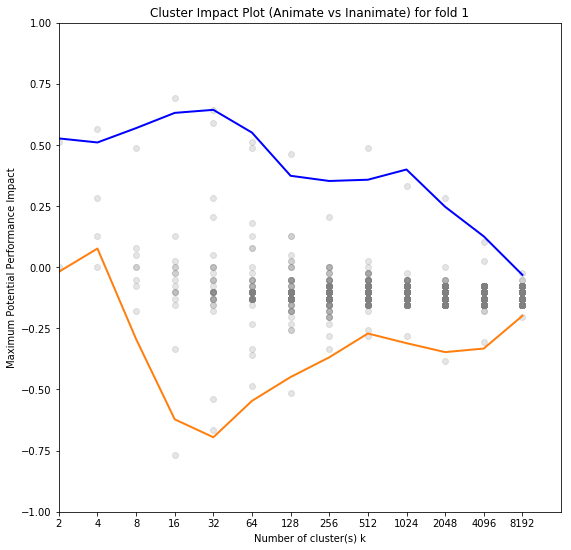

In [53]:
f = 1
clf_result = result[f]


fig = plt.figure(1,figsize=(9,9))
X = range(1,14,1)
xticks = []
#X = range(2,51,1)
anat = []
inat = []
for cl in X:
    xticks.append(2**cl)
    i = 0
    temp = []
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'go',color='grey',alpha=0.2)
        temp.append(clf_result[cl][item])
        i += 1
    anat.append(np.max(temp))
    inat.append(np.min(temp))

ahat = savgol_filter(anat, 5, 3)
ihat =  savgol_filter(inat, 5, 3)       
plt.plot(X,ahat, color='b',linewidth=2)
plt.plot(X,ihat, color='C1',linewidth=2)
plt.ylim([-1,1])
plt.xlim([1,14])
plt.xticks(X,xticks)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Maximum Potential Performance Impact")
plt.title('Cluster Impact Plot (Animate vs Inanimate) for fold '+ str(f))
plt.axvline(x=23 , color='black', linestyle='--',alpha=0.3)
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))

plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.png', format='png', dpi=500)

Text(0.5,1,'Scree Plot for fold 1')

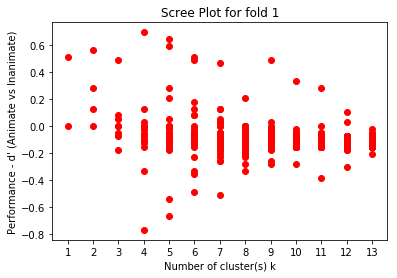

In [51]:
f = 1
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(1,14,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
#plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
#plt.savefig('../../results/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

In [ ]:
f = 3
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

In [ ]:
f = 4
clf_result = result[f]


plt.figure(1)
#X = range(1,51,1)
X = range(2,51,1)
for cl in X:
    i = 0
    for item in clf_result[cl].keys():
        plt.plot(cl,clf_result[cl][item],'ro')
        i += 1
        
plt.xticks(X)
plt.xlabel('Number of cluster(s) k')
plt.ylabel("Performance - d' (Animate vs Inanimate)")
plt.title('Scree Plot for fold '+ str(f))
plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
plt.savefig('../../results/scree/'+str(method)+'_results_fold_'+str(f)+'.svg', format='svg', dpi=1200)

(1, 0.4871794871794872, 0.0)
(1, 0.435897435897436, 0.0)
(1, 0.05128205128205121, -0.02564102564102566)
(1, 0.025641025641025772, -0.15384615384615385)
(1, 0.0, -0.1282051282051282)
(1, 0.10256410256410242, -0.1282051282051282)
(1, 0.0, -0.20512820512820507)
(1, 0.07692307692307687, -0.23076923076923073)
(1, 0.41025641025641024, -0.7948717948717948)
(1, 0.6410256410256411, -0.5128205128205128)
(1, 0.6153846153846154, -0.8205128205128205)
(1, 0.5897435897435898, -0.7948717948717948)
(1, 0.8461538461538461, -0.8205128205128205)
(1, 0.8461538461538461, -0.8205128205128205)
(1, 0.7692307692307692, -0.8461538461538461)
(1, 0.7948717948717948, -0.8461538461538461)
(1, 0.7692307692307693, -0.8461538461538461)
(1, 0.7435897435897436, -0.7692307692307693)
(1, 0.8974358974358975, -0.8717948717948718)
(1, 0.8974358974358975, -0.8717948717948718)
(1, 0.9230769230769231, -0.8974358974358975)
(1, 0.8461538461538461, -0.8974358974358974)
(1, 0.8974358974358975, -0.8974358974358974)
(1, 0.871794871794

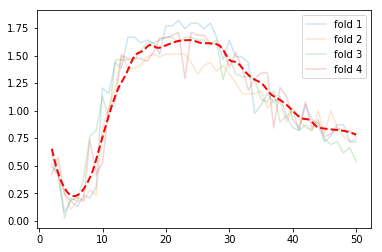

In [22]:
#Find MaxAd', MaxId' and its average
plt.figure()
noc = 4
for i in range(1,noc+1,1):
    X = []
    Y = []
    for j in range(2,51,1):
        X.append(j)
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        avg = float(maxa - (maxi))
        Y.append(avg)
    #print X,Y
    plt.plot(X,Y, alpha=0.2, label='fold '+str(i))

x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)
yhat = savgol_filter(y_smooth, 51, 3) # window size 51, polynomial order 3

plt.plot(x_smooth,yhat, 'r--', linewidth=2)
plt.ylabel('')
#plt.plot(x_smooth, y_smooth, 'r--', linewidth=1)
plt.legend()

In [21]:
y_sm

array([0.42105263, 0.57894737, 0.23684211, 0.18421053, 0.21052632,
       0.18421053, 0.73684211, 0.42105263, 0.52631579, 1.02631579,
       1.07894737, 1.5       , 1.47368421, 1.47368421, 1.47368421,
       1.44736842, 1.52631579, 1.65789474, 1.65789474, 1.68421053,
       1.71052632, 1.28947368, 1.71052632, 1.68421053, 1.68421053,
       1.60526316, 1.60526316, 1.55263158, 1.39473684, 1.52631579,
       1.39473684, 1.18421053, 1.28947368, 1.34210526, 1.34210526,
       0.84210526, 1.21052632, 1.13157895, 0.92105263, 0.84210526,
       1.07894737, 0.84210526, 0.92105263, 0.76315789, 0.78947368,
       0.84210526, 0.81578947, 0.81578947, 0.76315789])

100


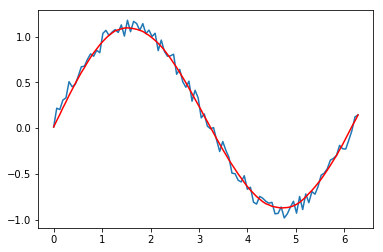

In [37]:
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

print(len(yhat))
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

0.365384615385 19 19 0.3562842289689549


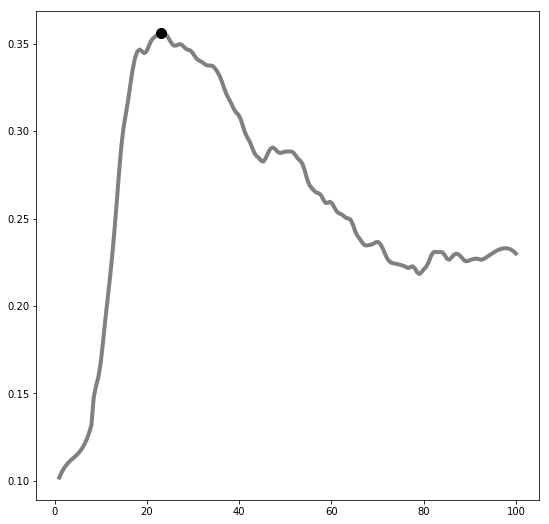

In [60]:
#Smooth average graph

noc = 1
flag = 0
X = range(1,101,1)
an_fold =[]
ian_fold = []
Y = []
for i in range(1,noc+1,1):
    if i == 2:
        flag = 1
    for j in range(1,101,1):
        temp = []
        for key, value in result[i][j].iteritems():
            temp.append(value)
        maxa = max(temp)
        maxi = min(temp)
        if flag == 0:
            an_fold.append(maxa)
            ian_fold.append(maxi)
        else:
            an_fold[j-2] += maxa
            ian_fold[j-2] = maxi

for j in range(1,101,1):
    maxa = (an_fold[j-2]) / 4.
    maxi = (ian_fold[j-2]) /4.
    diff = maxa - maxi
    Y.append(diff)
    
x_sm = np.array(X)
y_sm = np.array(Y)

x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)
y_smooth = spline(X, Y, x_smooth)
yhat = savgol_filter(y_smooth, 29, 3) # window size 51, polynomial order 3

plt.figure(figsize=((9,9)))
plt.plot(x_smooth, yhat, 'grey', linewidth=4)
#plt.plot(Y.index(max(Y))+1,max(yhat),'o')
plt.plot(23,max(yhat),'o',c='black',markersize=10)
#plt.xlabel('Number of cluster(s) k')
#plt.ylabel("Average Performance")
plt.savefig('../../results/'+str(method)+'_results_fold_avg.png', format='png', dpi=500)
print max(Y), Y.index(max(Y))+1, Y.index(max(Y))+1,max(yhat)

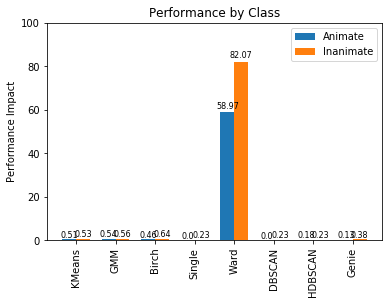

In [11]:
#D' histogram for animate and inanimate double bars for different clustering techniques
#GMM- 0.538461538462 0.564102564103
#KMeans - 0.512820512821 0.538461538462
labels = ['KMeans','GMM','Birch','Single','Ward','DBSCAN','HDBSCAN','Genie']
animate_means = [0.51,0.54, 0.46 ,0,  58.97,0,0.18,0.13]
inanimate_means = [0.53,0.56, 0.64 ,0.23,  82.07, 0.23,0.23,0.38]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, animate_means, width, label='Animate')
rects2 = ax.bar(x + width/2, inanimate_means, width, label='Inanimate')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Impact')
ax.set_title('Performance by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation=90)
ax.legend()
plt.ylim([0.,100.])

def autolabel(rects, xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom',size=8)
        
autolabel(rects1)
autolabel(rects2)
#plt.savefig('../../results//clustering_results.png', format='png')

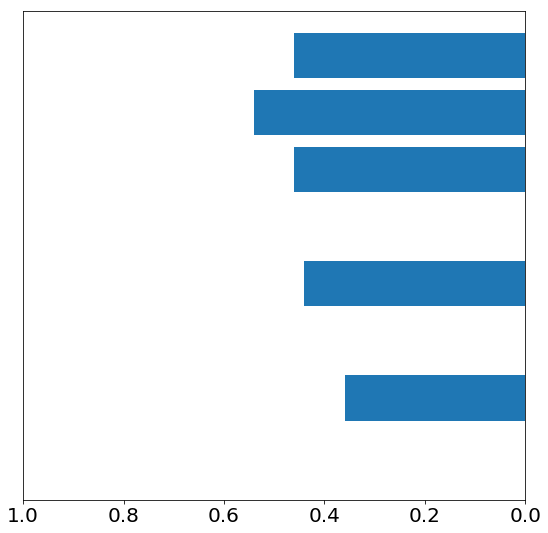

In [19]:
fig, ax = plt.subplots(figsize=(9,9))
X = range(1,9)
lbl = ['KMeans','GMM','Birch','Single','Ward','DBSCAN','HDBSCAN','Genie']
Y = [0.46,0.54, 0.46 ,0,0.44,0, 0.36,0]
plt.xlim([0,1.0])
plt.yticks([])
ax.invert_yaxis()  
ax.invert_xaxis()
#ax2 = ax.twinx()
#ax2.set_ylim(ax.get_ylim())
#ax2.set_yticks(X)
#ax2.set_yticklabels(lbl)
plt.barh(X,Y)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.savefig('../../results/ana_clustering_results.png', format='png')

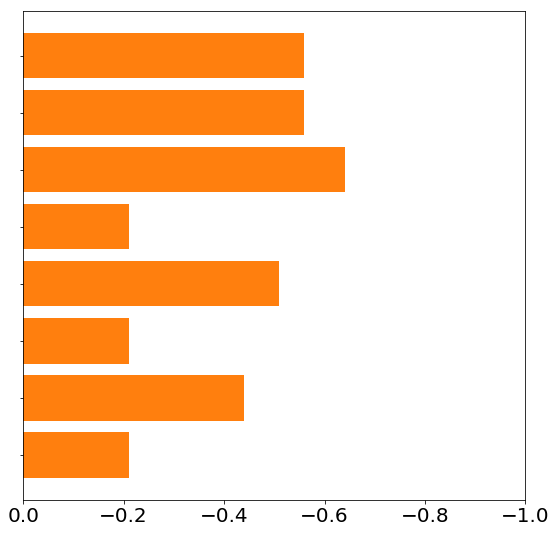

In [20]:
fig, ax = plt.subplots(figsize=(9,9))
X = range(1,9)
plt.xlim([0,-1.])
lbl = ['KMeans','GMM','Birch','Single','Ward','DBSCAN','HDBSCAN','Genie']
Y = [-0.56,-0.56, -0.64,-0.21 ,-0.51,-0.21 ,-0.44,-0.21]
ax.invert_yaxis() 
#ax.set_yticks(X)
#ax.set_yticklabels(lbl)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.set_yticklabels([])
plt.barh(X,Y, color='C1')
plt.savefig('../../results/ina_clustering_results.png', format='png')